# The analysis for journey data

## An analysis for the cycle hire data

We will consider the influence of multiple factors of the physical environment on the number of travels

In [38]:
# load libraries

import os
import csv
import json
import urllib.request
from requests import get

import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.plot

import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import linear_model
import statsmodels.api as sm


In [2]:
# set path
points_path = os.path.join('data', 'cycles', 'points')
points_fn = 'BikePoints.geojson'
points_parquet_fn = 'docking_stations.geoparquet'
journeys_path = os.path.join('data', 'cycles', 'journeys')
journeys_gdf_fn = 'journeys_gdf.geoparquet'
journeys_df_fn = 'journeys_df.parquet'
elevation_path = os.path.join('data', 'elevation', 'london_elevation.tif')
geom_path = os.path.join('data', 'London_geometry')
lsoa_fn = 'LSOA_2011_London_gen_MHW.shp'
cc_fn = 'CentralUltraLowEmissionZone.gpkg'

In [3]:
# load data
journeys_gdf = gpd.read_parquet(os.path.join(journeys_path, journeys_gdf_fn))
journeys_df = gpd.read_parquet(os.path.join(journeys_path, journeys_df_fn))

## Basic analysis of the data

First, looking at the characteristics of the dataset.

In [4]:
# filter by start date
journeys_df = journeys_df[journeys_df['Start date'] >= '2022-12-01'].copy()

<Axes: xlabel='Start date,Start date'>

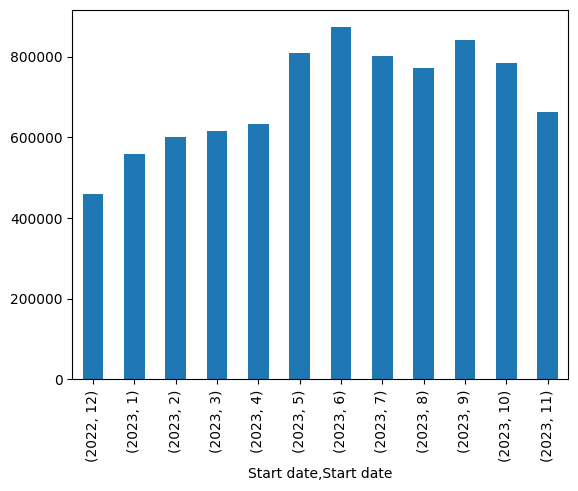

In [5]:
# draw bar chart by month
journeys_df.groupby([journeys_df['Start date'].dt.year, journeys_df['Start date'].dt.month]).Number.count().plot(kind = 'bar')

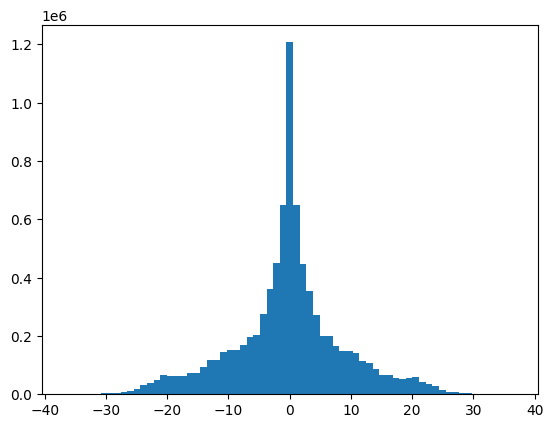

In [6]:
# draw histogram of height distance

# set up plot
fig, ax = plt.subplots(1, 1)

# add histogram
ax.hist(
    journeys_df.height_diff,
    bins = 81
)

# set limits
ax.set_xlim(-40.5, 40.5)

plt.show()


In [7]:
journeys_df[journeys_df['Start station'] != journeys_df['End station']].height_diff.mean()

-0.22877766

In [8]:
scipy.stats.ttest_1samp(journeys_df.height_diff, popmean = 0)

TtestResult(statistic=-69.61426590290411, pvalue=0.0, df=8414630)

### The average height difference

The average of the height difference is -0.22 m. From the one sample T-test, the null hypothesis of average being 0 is rejected, and is statistically significant, concluding that on average the shared cycles are used more downhill than uphill.

(array([1.443276e+06, 2.202603e+06, 1.763172e+06, 1.216677e+06,
        7.556930e+05, 4.513590e+05, 2.545110e+05, 1.445900e+05,
        8.518200e+04, 4.782000e+04, 2.491700e+04, 1.258100e+04,
        6.461000e+03, 2.777000e+03, 1.500000e+03, 9.490000e+02,
        3.900000e+02, 1.320000e+02, 3.600000e+01, 5.000000e+00]),
 array([    0.        ,   858.53878817,  1717.07757635,  2575.61636452,
         3434.15515269,  4292.69394087,  5151.23272904,  6009.77151721,
         6868.31030539,  7726.84909356,  8585.38788173,  9443.92666991,
        10302.46545808, 11161.00424626, 12019.54303443, 12878.0818226 ,
        13736.62061078, 14595.15939895, 15453.69818712, 16312.2369753 ,
        17170.77576347]),
 <BarContainer object of 20 artists>)

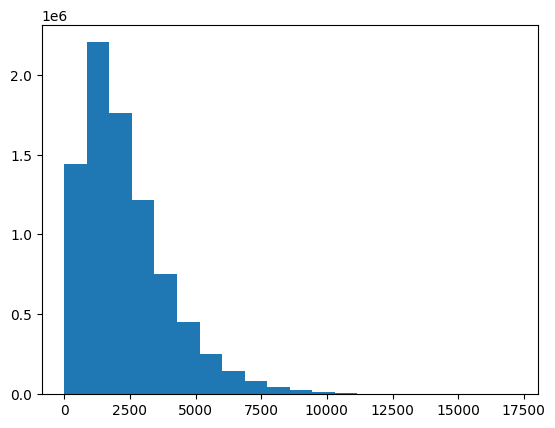

In [9]:
# draw scatter plot


plt.hist(journeys_df['distance'], bins = 20)


In [10]:
# calculate average speed
journeys_df['ave_speed'] = journeys_df['distance'] / journeys_df['Total duration (ms)'] * 1000

## Consider the bike types

The 2 types of bikes existing may make a difference.

In [11]:
# compare the distances
journeys_df.groupby(by = 'Bike model').distance.describe()

C:\Users\Soki\AppData\Local\Temp\ipykernel_27476\2878216079.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  journeys_df.groupby(by = 'Bike model').distance.describe()


,count,mean,std,min,25%,50%,75%,max
Bike model,,,,,,,,
CLASSIC,7808234.0,2279.410865,1656.945009,0.0,1085.307181,1906.495847,3087.379142,17170.775763
PBSC_EBIKE,606397.0,3124.616509,2014.003074,0.0,1651.065859,2757.887126,4181.514950,16682.920172


In [12]:
# compare the height difference
journeys_df.groupby(by = 'Bike model').height_diff.describe()

C:\Users\Soki\AppData\Local\Temp\ipykernel_27476\2032955772.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  journeys_df.groupby(by = 'Bike model').height_diff.describe()


,count,mean,std,min,25%,50%,75%,max
Bike model,,,,,,,,
CLASSIC,7808234.0,-0.231310,9.00606,-43.875999,-3.996001,0.0,3.60825,43.875999
PBSC_EBIKE,606397.0,-0.073767,11.01310,-43.214748,-6.377500,0.0,6.23700,43.779247


In [62]:
journeys_df.groupby(by = ['start_cc_zone', 'end_cc_zone']).height_diff.describe()

count      mean        std        min  \
start_cc_zone end_cc_zone                                              
False         False        3788352.0 -0.173816   7.835636 -43.875999   
              True         1432552.0 -0.037089  10.530090 -43.293499   
True          False        1265977.0 -0.726798  10.431625 -37.391251   
              True         1927750.0 -0.113674   9.589618 -36.318249   

                                25%     50%       75%        max  
start_cc_zone end_cc_zone                                         
False         False       -2.899501  0.0000  2.700500  43.875999  
              True        -5.550250 -0.1775  6.324749  36.418751  
True          False       -7.102500 -0.1495  4.493000  43.117249  
              True        -5.281001  0.0000  5.079500  36.318249

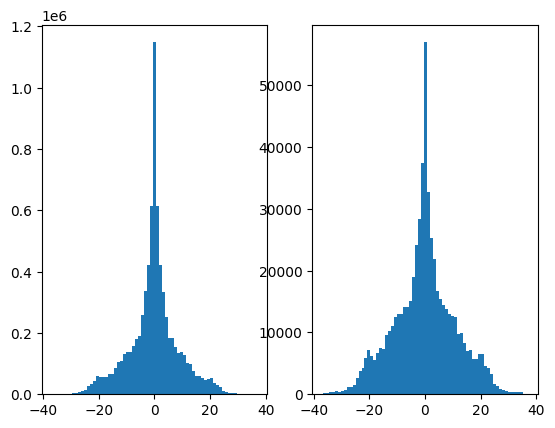

In [63]:
# set up plot
fig, axes = plt.subplots(1, 2)

# add histogram for classic cycles
axes[0].hist(
    journeys_df[journeys_df['Bike model'] == 'CLASSIC'].height_diff,
    bins = 81
)

# add histogram for ebikes
axes[1].hist(
    journeys_df[journeys_df['Bike model'] == 'PBSC_EBIKE'].height_diff,
    bins = 81
)


# set limits
for ax in axes:
    ax.set_xlim(-40.5, 40.5)

plt.show()

In [64]:
# conduct t-test

scipy.stats.ttest_ind(
    journeys_df[journeys_df['Bike model'] == 'CLASSIC'].height_diff,
    journeys_df[journeys_df['Bike model'] == 'PBSC_EBIKE'].height_diff
)

# the small p-value indicates there is significant difference in the distributions of the two types of bikes

TtestResult(statistic=-12.893918258674379, pvalue=4.874543134223036e-38, df=8414629.0)

In [65]:
# OD analysis

od_df = journeys_df.groupby(['start_id', 'end_id', 'Bike model']).Number.count().reset_index()

C:\Users\Soki\AppData\Local\Temp\ipykernel_27476\2280827154.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  od_df = journeys_df.groupby(['start_id', 'end_id', 'Bike model']).Number.count().reset_index()


In [66]:
# join with bike points data

# read points data
points_gdf = gpd.read_parquet(os.path.join(points_path, points_parquet_fn)).set_index('id')

# make ports into numeric
points_gdf['ports'] = points_gdf.ports.astype('int')


In [67]:
# join with points
od_df = od_df.join(points_gdf.add_prefix('start_'), on = 'start_id').join(points_gdf.add_prefix('end_'), on = 'end_id')

In [68]:
# convert number of ports into numeric
numbers = ['start_ports', 'end_ports']
for c in numbers:
    od_df[c] = od_df[c].astype('int')

In [69]:
# define start and end points as GeoSeries
start_geoseries = gpd.GeoSeries(od_df.start_geometry, crs = 'EPSG:27700')
end_geoseries = gpd.GeoSeries(od_df.end_geometry, crs = 'EPSG:27700')

# calculate distance and store in df
od_df['distance'] = start_geoseries.distance(end_geoseries, align = False)

# calculate height difference and store in df
od_df['height_diff'] = od_df.end_height - od_df.start_height

In [70]:
# group by MSOA
msoa_od = od_df[od_df['Bike model'] == 'CLASSIC'].groupby(['start_MSOA11CD', 'end_MSOA11CD']).agg(
    {
        'Number': 'sum',
        'distance': 'mean',
        'height_diff': 'mean',
    }
).reset_index()

# summarise the point information by MSOA as well
points_msoa = points_gdf.groupby('MSOA11CD').agg(
    {
        'name': 'count',
        'ports': 'sum',
        'height': 'mean'
    }
).rename(columns = {'name': 'stations', 'ports': 'total_ports', 'height': 'mean_height'})


In [71]:
msoa_od = msoa_od.join(points_msoa.add_prefix('start_'), on = 'start_MSOA11CD').join(points_msoa.add_prefix('end_'), on = 'end_MSOA11CD')

<Axes: xlabel='Start date'>

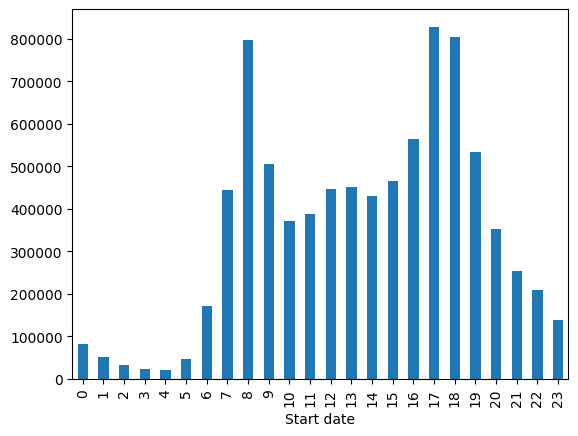

In [72]:
journeys_df.groupby(journeys_df['Start date'].dt.hour).Number.count().plot(kind = 'bar')

In [73]:
# extract one origin or destination to begin
# chose the City of London as starting point for analysis

target_msoa = 'E02000001'

city_df = msoa_od[((msoa_od.start_MSOA11CD == target_msoa) | (msoa_od.end_MSOA11CD == target_msoa)) & (msoa_od.start_MSOA11CD != msoa_od.end_MSOA11CD)].copy()

In [74]:
# create columns containing data for the 'other' area

#city_df['other_stations'] = []
#city_df['other_total_ports'] = []
#city_df['other_mean_height'] = []
#city_df['is_outbound'] = []

for idx, row in city_df.iterrows():
    if(row['start_MSOA11CD'] == target_msoa):
        city_df.loc[idx, 'other_stations'] = row['end_stations']
        city_df.loc[idx, 'other_total_ports'] = row['end_total_ports']
        city_df.loc[idx, 'other_mean_height'] = row['end_mean_height']
        city_df.loc[idx, 'is_outbound'] = 0
    else:
        city_df.loc[idx, 'other_stations'] = row['start_stations']
        city_df.loc[idx, 'other_total_ports'] = row['start_total_ports']
        city_df.loc[idx, 'other_mean_height'] = row['start_mean_height']
        city_df.loc[idx, 'is_outbound'] = 1      

city_df


,start_MSOA11CD,end_MSOA11CD,Number,distance,height_diff,start_stations,start_total_ports,start_mean_height,end_stations,end_total_ports,end_mean_height,other_stations,other_total_ports,other_mean_height,is_outbound
1,E02000001,E02000180,502,3715.141455,18.149588,38,1008,13.108163,1,24,31.257751,1.0,24.0,31.257751,0.0
2,E02000001,E02000183,407,4595.559996,17.980461,38,1008,13.108163,2,53,31.088625,2.0,53.0,31.088625,0.0
3,E02000001,E02000184,1468,4105.302768,12.400024,38,1008,13.108163,4,156,25.508188,4.0,156.0,25.508188,0.0
4,E02000001,E02000186,1064,4093.716044,15.992430,38,1008,13.108163,8,244,29.100594,8.0,244.0,29.100594,0.0
5,E02000001,E02000187,2815,3232.230471,8.932254,38,1008,13.108163,6,166,22.040419,6.0,166.0,22.040419,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24800,E02000983,E02000001,2252,4315.636908,8.164514,5,133,4.943650,38,1008,13.108163,5.0,133.0,4.943650,1.0
24960,E02006801,E02000001,52297,2123.247952,8.557644,18,468,4.550519,38,1008,13.108163,18.0,468.0,4.550519,1.0
25120,E02006802,E02000001,8526,2106.171447,9.716639,10,342,3.391525,38,1008,13.108163,10.0,342.0,3.391525,1.0
25280,E02006853,E02000001,1496,5441.921509,9.689497,3,73,3.418667,38,1008,13.108163,3.0,73.0,3.418667,1.0


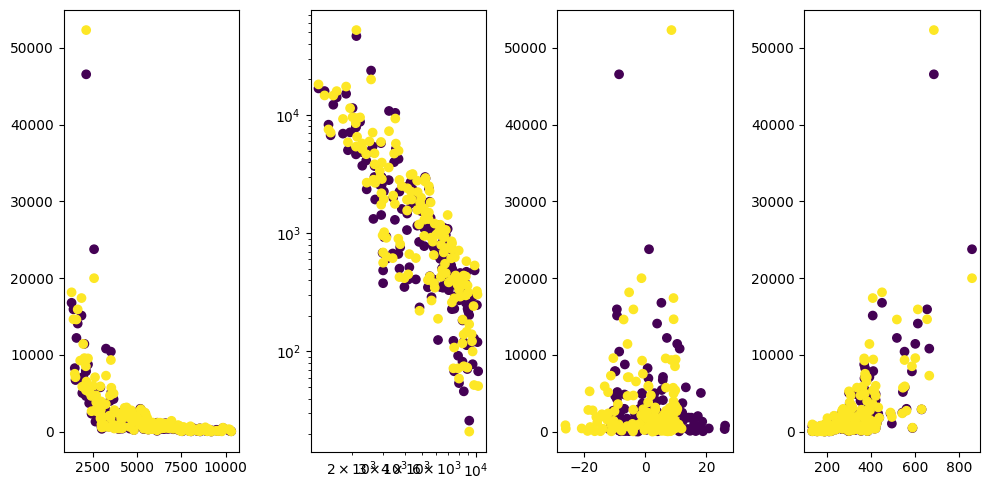

In [75]:
fig, axes = plt.subplots(1,4, figsize = (10, 5))

# distance
axes[0].scatter(
    x = city_df.distance,
    y = city_df.Number,
    c = city_df.is_outbound
)

axes[1].scatter(
    x = city_df.distance,
    y = city_df.Number,
    c = city_df.is_outbound
)


# take a double log scale for the second one
axes[1].set_xscale('log')
axes[1].set_yscale('log')

# height difference
axes[2].scatter(
    x = city_df.height_diff,
    y = city_df.Number,
    c = city_df.is_outbound
)

# total ports
axes[3].scatter(
    x = np.sqrt(city_df.start_total_ports * city_df.end_total_ports),
    y = city_df.Number,
    c = city_df.is_outbound
)

plt.tight_layout()
plt.show()

In [78]:
# check the power law behind distance

# get log for distance and trips
city_df['distance_log'] = np.log(city_df.distance)
city_df['number_log'] = np.log(city_df.Number)


log_model = sm.OLS(endog = city_df['number_log'], exog = sm.add_constant(city_df['distance_log'])).fit()
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             number_log   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     783.4
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           1.49e-87
Time:                        00:50:19   Log-Likelihood:                -365.62
No. Observations:                 318   AIC:                             735.2
Df Residuals:                     316   BIC:                             742.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           26.4892      0.700     37.841      0.000      25.112      27.866
distance_log    -2.3132      0.083    -27.989      0.000      -2.476      -2.151
==============================================================================
Omnibus:                        7.908   Durbin-Watson:                   1.419
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                7.969
Skew:                          -0.387   Prob(JB):                       0.0186
Kurtosis:                       3.045   Cond. No.                         140.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [90]:
# calculate inverse squared value
city_df['distance_inv_sq'] = city_df.distance.astype('float') ** (-2)

Text(0.5, 1.0, 'Correlation Matrix')

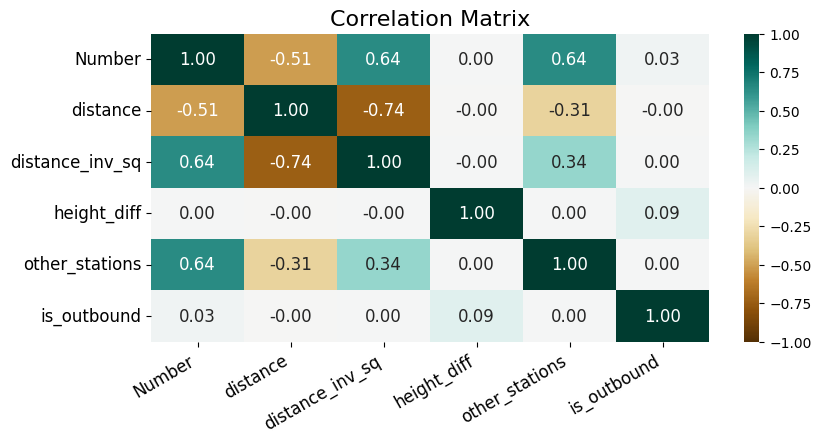

In [91]:
# check multi-colinearity
df = city_df[['Number', 'distance', 'distance_inv_sq', 'height_diff', 'other_stations', 'is_outbound']].copy()
plt.figure(figsize = (9, 4))
heatmap = sns.heatmap(df.corr(), annot = True, vmin = -1, vmax = 1, cmap = 'BrBG', fmt = '.2f', annot_kws = {'fontsize': 12})
# plt.rcParams["axes.grid"] = False
# f = plt.figure(figsize=(10, 8))
# plt.matshow(df.corr(), fignum=f.number, cmap = 'Blues')
plt.xticks(fontsize = 12, rotation=30, ha = 'right') # rotation of xticks
plt.yticks(fontsize = 12)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [94]:
# run linear regression

# set dependent variables
x = city_df[['distance_inv_sq', 'height_diff', 'other_stations', 'is_outbound']]
y = city_df.Number

model1 = sm.OLS(endog = y, exog = sm.add_constant(x)).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Number   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     127.3
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           2.21e-64
Time:                        01:17:57   Log-Likelihood:                -3020.4
No. Observations:                 318   AIC:                             6051.
Df Residuals:                     313   BIC:                             6070.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -2453.3698    348.231     -7.045      0.000   -3138.539   -1768.201
distance_inv_sq  2.484e+10   1.92e+09     12.935      0.000    2.11e+10    2.86e+10
height_diff         0.7890     20.340      0.039      0.969     -39.232      40.810
other_stations    635.3916     49.145     12.929      0.000     538.695     732.088
is_outbound       291.4769    366.263      0.796      0.427    -429.171    1012.125
==============================================================================
Omnibus:                      489.460   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           100433.265
Skew:                           7.919   Prob(JB):                         0.00
Kurtosis:                      88.610   Cond. No.                     9.48e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.87e-12. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""